In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

np.random.seed(42)

In [2]:
def generate_personality_dataset(n_samples=500):
    data = np.random.randint(1, 6, size=(n_samples, 20))
    extroversion_bias = [1, 2, 3, 8, 9, 10, 14, 15, 16, 17, 18]  # Removed 20 to avoid index error
    introversion_bias = [4, 5, 6, 7, 11, 12, 13, 19]
    data = np.random.randint(1, 6, size=(n_samples, 20))
    data[:, extroversion_bias] += np.random.randint(0, 2, size=(n_samples, len(extroversion_bias)))
    data[:, introversion_bias] -= np.random.randint(0, 2, size=(n_samples, len(introversion_bias)))
    data = np.clip(data, 1, 5)
    extroversion_score = data[:, extroversion_bias].mean(axis=1)
    target = (extroversion_score > extroversion_score.mean()).astype(int)
    return data, target

In [3]:
X, y = generate_personality_dataset()

In [4]:
column_names = [f'Q{i+1}' for i in range(20)]
df = pd.DataFrame(X, columns=column_names)
df['Personality_Type'] = y

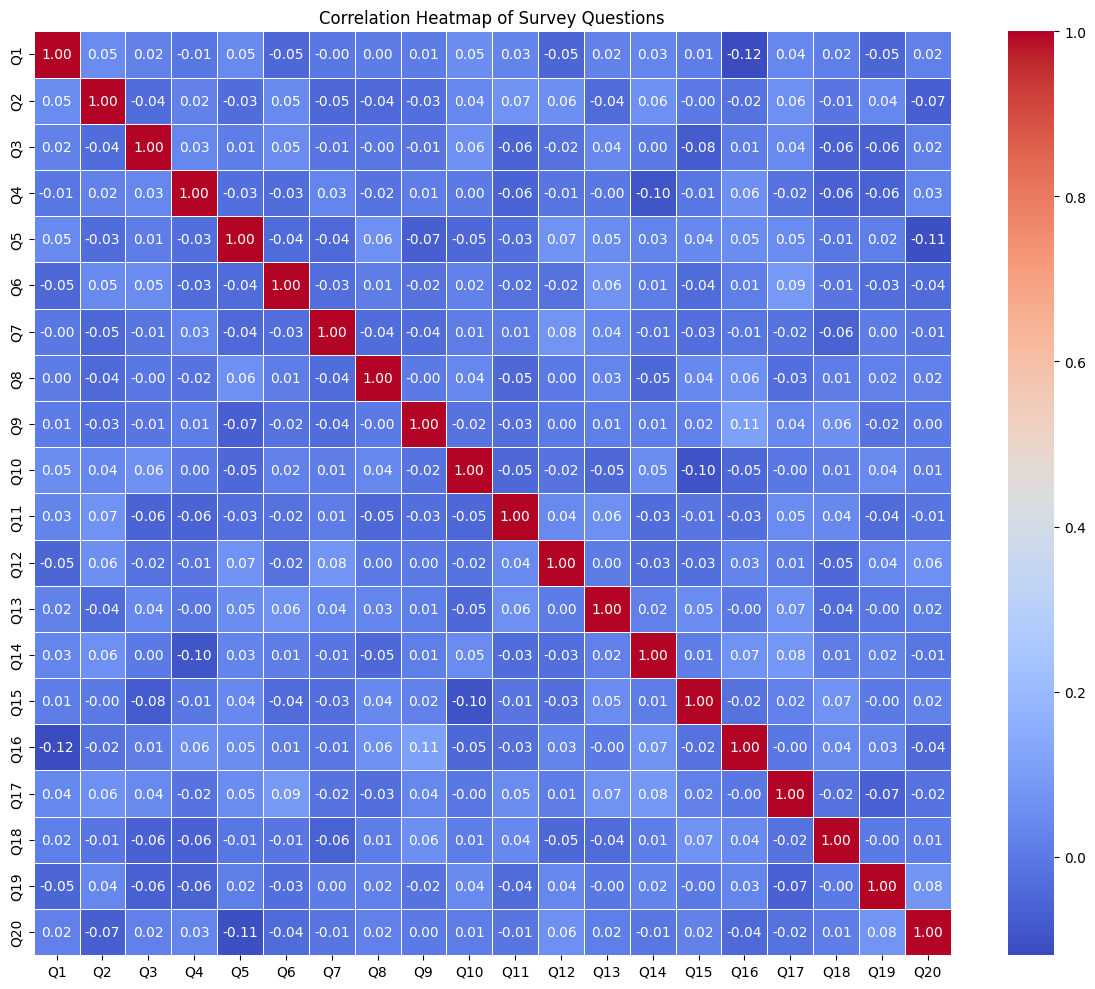

In [5]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[column_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap of Survey Questions')
plt.tight_layout()
plt.show()

In [6]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
def perform_factor_analysis(X_scaled, n_factors=4):
    fa = FactorAnalyzer(n_factors=n_factors, rotation=None)
    fa.fit(X_scaled)
    
    # Get factor loadings
    loadings = pd.DataFrame(
        fa.loadings_, 
        columns=[f'Factor{i+1}' for i in range(n_factors)], 
        index=column_names
    )
    
    # Scree plot
    ev, v = fa.get_eigenvalues()
    plt.plot(range(1, len(ev)+1), ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.show()
    
    return loadings, fa


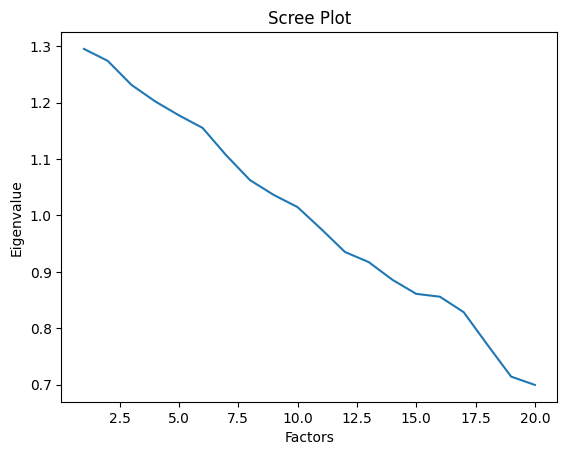

Factor Loadings:
      Factor1   Factor2   Factor3   Factor4
Q1  -0.121362  0.107400  0.011623  0.053258
Q2  -0.029776  0.152396 -0.009085  0.139012
Q3   0.001095  0.119146 -0.255781 -0.122689
Q4   0.047517 -0.088446 -0.132335 -0.168629
Q5   0.052282  0.100774  0.110168 -0.070434
Q6   0.011269  0.187184 -0.083655 -0.026009
Q7  -0.012460 -0.051722 -0.076515 -0.104181
Q8   0.062334 -0.055328  0.027032 -0.018216
Q9   0.109457  0.004982  0.046340  0.033949
Q10 -0.057068  0.026252 -0.293238  0.240763
Q11 -0.040773  0.084177  0.128247 -0.013764
Q12  0.025312 -0.021061  0.001417 -0.059011
Q13  0.002020  0.153030  0.075916 -0.177005
Q14  0.060261  0.220452  0.011371  0.210018
Q15 -0.010171 -0.009560  0.300009 -0.027699
Q16  0.997582  0.009585 -0.023777  0.008034
Q17 -0.002888  0.404036  0.029154 -0.053803
Q18  0.043752 -0.034957  0.187043  0.186470
Q19  0.031495 -0.119597  0.015099  0.155369
Q20 -0.039984 -0.130021 -0.024925  0.007082


In [8]:
loadings, fa = perform_factor_analysis(X_scaled)
print("Factor Loadings:")
print(loadings)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_name):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test_scaled)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Model Performance:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

Raw Features Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        47
           1       0.83      0.92      0.88        53

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



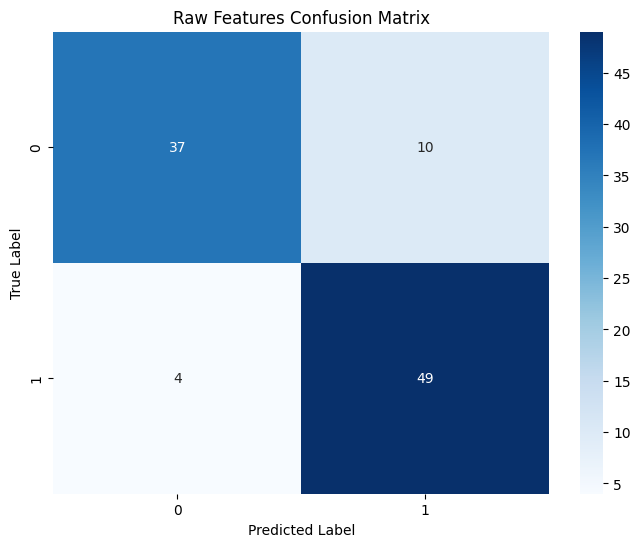

In [11]:
raw_accuracy = train_and_evaluate_model(X_train, X_test, y_train, y_test, "Raw Features")


In [12]:
# Extract factor scores
fa = FactorAnalyzer(n_factors=4, rotation=None)
factor_scores = fa.fit_transform(X_scaled)

# Split factor scores
X_factor_train, X_factor_test, y_train, y_test = train_test_split(
    factor_scores, y, test_size=0.2, random_state=42
)

Factor Analysis Model Performance:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59        47
           1       0.64      0.66      0.65        53

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



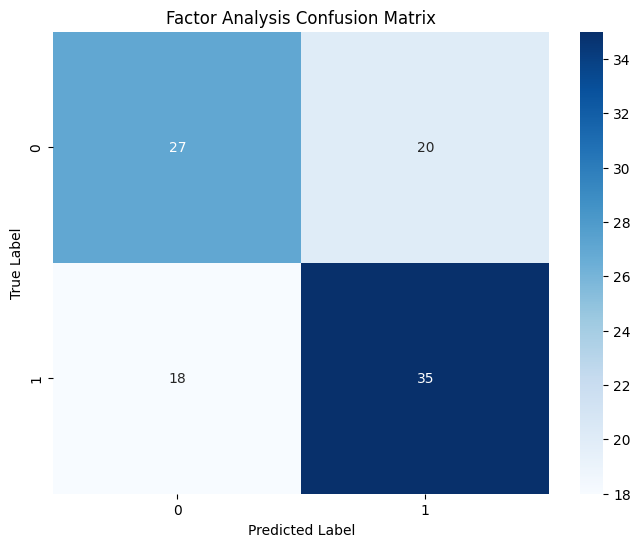

In [13]:
factor_accuracy = train_and_evaluate_model(X_factor_train, X_factor_test, y_train, y_test, "Factor Analysis")


In [14]:
print("\nModel Comparison:")
print(f"Raw Features Model Accuracy: {raw_accuracy:.2%}")
print(f"Factor Analysis Model Accuracy: {factor_accuracy:.2%}")



Model Comparison:
Raw Features Model Accuracy: 86.00%
Factor Analysis Model Accuracy: 62.00%



Bonus: Factor Number Experiment
3 Factors Model Performance:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        47
           1       0.63      0.62      0.63        53

    accuracy                           0.61       100
   macro avg       0.61      0.61      0.61       100
weighted avg       0.61      0.61      0.61       100



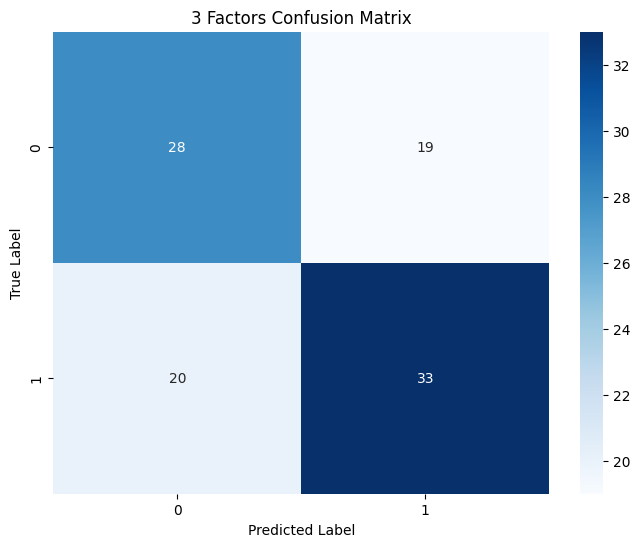

4 Factors Model Performance:
              precision    recall  f1-score   support

           0       0.60      0.57      0.59        47
           1       0.64      0.66      0.65        53

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



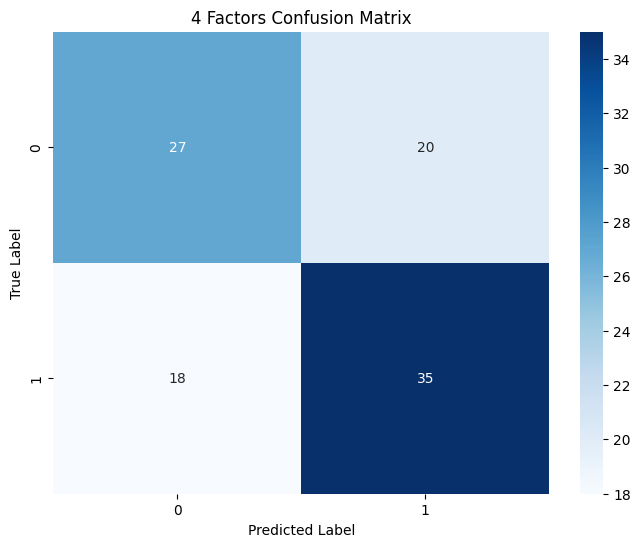

5 Factors Model Performance:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        47
           1       0.64      0.68      0.66        53

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



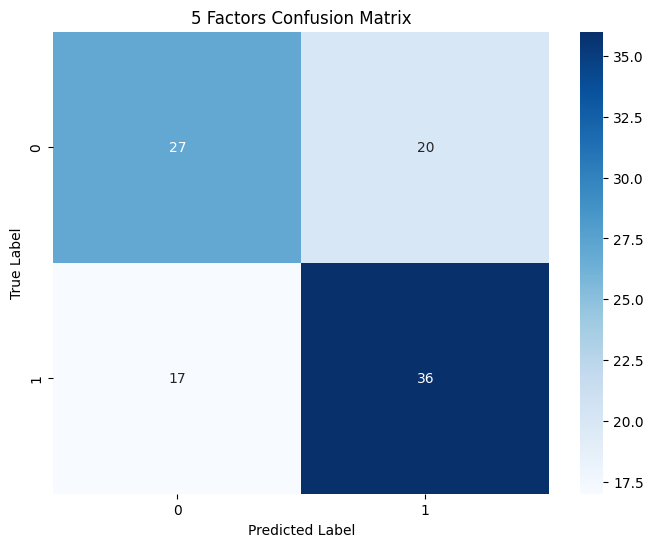

7 Factors Model Performance:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        47
           1       0.65      0.64      0.65        53

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



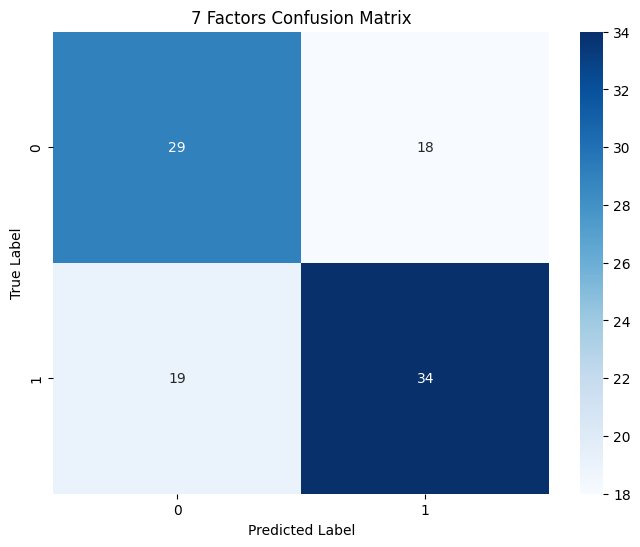

In [15]:
print("\nBonus: Factor Number Experiment")
factor_accuracies = []
for n_factors in [3, 4, 5, 7]:
    fa = FactorAnalyzer(n_factors=n_factors, rotation=None)
    factor_scores = fa.fit_transform(X_scaled)
    
    X_factor_train, X_factor_test, y_train, y_test = train_test_split(
        factor_scores, y, test_size=0.2, random_state=42
    )
    
    accuracy = train_and_evaluate_model(X_factor_train, X_factor_test, y_train, y_test, f"{n_factors} Factors")
    factor_accuracies.append((n_factors, accuracy))


In [16]:

print("\nFactor Number vs Accuracy:")
for factors, acc in factor_accuracies:
    print(f"{factors} Factors: {acc:.2%}")


Factor Number vs Accuracy:
3 Factors: 61.00%
4 Factors: 62.00%
5 Factors: 63.00%
7 Factors: 63.00%
